In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import sqrt
from numpy import split
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
import random
random.seed(123)

In [3]:
res_time = '60T'
edificio = 'A'

In [4]:
data = pd.read_csv('data-model-consumo' + edificio + '-' + res_time + '.csv', sep=";", index_col=0)
print(data.shape)
data.head(3)

(7049, 24)


,Fecha,dif_cons,V2,V4,V12,V26,V5_0,V5_1,V5_2,Hora_1,...,Season_3,Season_4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,dpv
0,2021-01-07 10:00:00+00:00,12.08,20.90,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,4.9,88.2,45.9,0.5,211.7,0.1,3.1,0.1
1,2021-01-07 11:00:00+00:00,9.54,20.99,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,5.1,88.4,42.3,0.4,211.8,0.1,3.3,0.1
2,2021-01-07 12:00:00+00:00,8.83,20.97,4.0,23.47,0.2,0.0,1.0,0.0,1.0,...,0.0,0.0,5.3,88.6,52.7,0.6,212.8,0.2,3.6,0.1


In [5]:
data.columns

Index(['Fecha', 'dif_cons', 'V2', 'V4', 'V12', 'V26', 'V5_0', 'V5_1', 'V5_2',
       'Hora_1', 'Hora_2', 'Hora_3', 'Season_1', 'Season_2', 'Season_3',
       'Season_4', 'tmed', 'hrmed', 'radmed', 'vvmed', 'dvmed', 'prec',
       'dewpt', 'dpv'],
      dtype='object')

In [26]:
data = data[['dif_cons', 'V4']]

In [27]:
data.describe()

,dif_cons,V4
count,7049.000000,7049.000000
mean,5.244476,7.726344
std,2.790009,2.630939
min,0.450000,3.000000
25%,3.100000,6.000000
50%,4.710000,8.000000
75%,6.970000,9.000000
max,20.350000,16.000000


In [28]:
df = data

In [9]:
def split_dataset(data, per_train):
    train = data[0:int(np.ceil(df.shape[0]*per_train))]
    test = data[int(np.ceil(df.shape[0]*per_train)): int(np.ceil(df.shape[0]*(per_train+per_test)))]
    val = data[int(np.ceil(df.shape[0]*(per_train+per_test))):]
    
    train = array(train)
    test = array(test)
    val = array(val)
    return train, test, val

In [29]:
def split_dataset(data, per_train):
    train = data[0:int(np.ceil(df.shape[0]*per_train))]
    val = data[int(np.ceil(df.shape[0]*per_train)): int(np.ceil(df.shape[0]*(per_train+per_test)))]
    test = data[int(np.ceil(df.shape[0]*(per_train+per_test))):]
    #Escalado en train y test por separado. Si no se hace aquí ya no se puede porque todo lo que sigue es con arrays 3D
    scaler_y = StandardScaler()
    train_y = scaler_y.fit_transform(train[:,0].reshape(-1, 1))
    val_y = scaler_y.fit_transform(val[:,0].reshape(-1, 1))
    test_y = scaler_y.transform(test[:,0].reshape(-1, 1))
    scaler_x = StandardScaler()
    train_x = scaler_x.fit_transform(train[:,1:]) 
    val_x = scaler_x.fit_transform(val[:,1:]) 
    test_x = scaler_x.transform(test[:,1:])
    
    #Rehacemos los DataFrames con los datos escalados para poder hacer el split
    train = pd.concat([pd.DataFrame(train_y),pd.DataFrame(train_x)], axis=1)
    test = pd.concat([pd.DataFrame(test_y),pd.DataFrame(test_x)], axis=1)
    val = pd.concat([pd.DataFrame(val_y),pd.DataFrame(val_x)], axis=1)

    train = array(train)
    test = array(test)
    val = array(val)
    return train, test, val, scaler_x, scaler_y

In [160]:
# split en train y test
per_train = 0.7
per_test = 0.15
train, test, val, scaler_x, scaler_y = split_dataset(df.values, per_train)
print('shape: [muestras, pasos de tiempo, características]')
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

shape: [muestras, pasos de tiempo, características]
train shape: (4935, 2)
val shape: (1057, 2)
test shape: (1057, 2)


In [161]:
def to_supervised(train, n_input, n_out):
    # Ponemos los datos en 2D: una entrada para cada muestra y paso de tiempo con las n características
    data = train#.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # Pasamos por todo el conjunto de datos, de step en step
    for _ in range(len(data)):
        # Definimos cuando empieza el input, cuando acaba, e igual para el output
        # En este caso el output empieza cuando acaba el input
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Iteramos mientras haya ejemplos
        if out_end <= len(data):
            X.append(data[in_start:in_end, :]) # X son todas las variables en t
            y.append(data[in_end:out_end, 0])  # y es la temperatura en t+1 (si n_out=1)
        # Pasamos al siguiente instante de tiempo
        in_start += 1 #ESTO PARA CAMBIAR DE 1 a 2 H
    X = array(X)
    y = array(y)
    return X, y

In [162]:
n_input = 6
n_out = 1

In [164]:
train_x, train_y = to_supervised(train, n_input, n_out)
test_x, test_y = to_supervised(test, n_input, n_out)
val_x, val_y = to_supervised(val, n_input, n_out)
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)    

train_x shape: (4929, 6, 2)
train_y shape: (4929, 1)
val_x shape: (1051, 6, 2)
val_y shape: (1051, 1)
test_x shape: (1051, 6, 2)
test_y shape: (1051, 1)


In [165]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
print('n_timesteps:' , n_timesteps) 
print('n_features:'  , n_features)     
print('n_outputs:' , n_outputs)   

n_timesteps: 6
n_features: 2
n_outputs: 1


In [166]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, return_sequences=True))
model.add(TimeDistributed(Dense(50)))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = model.fit(train_x, train_y, epochs=200, batch_size=128, validation_data=(val_x, val_y),
                    verbose=2, shuffle=False, callbacks=stop_early)

Epoch 1/200
39/39 - 4s - loss: 0.4421 - val_loss: 0.8854 - 4s/epoch - 107ms/step
Epoch 2/200
39/39 - 1s - loss: 0.4332 - val_loss: 0.3646 - 580ms/epoch - 15ms/step
Epoch 3/200
39/39 - 1s - loss: 0.2435 - val_loss: 0.2797 - 685ms/epoch - 18ms/step
Epoch 4/200
39/39 - 1s - loss: 0.1937 - val_loss: 0.2523 - 597ms/epoch - 15ms/step
Epoch 5/200
39/39 - 1s - loss: 0.1691 - val_loss: 0.2733 - 569ms/epoch - 15ms/step
Epoch 6/200
39/39 - 1s - loss: 0.1953 - val_loss: 0.2060 - 601ms/epoch - 15ms/step
Epoch 7/200
39/39 - 1s - loss: 0.1366 - val_loss: 0.2262 - 541ms/epoch - 14ms/step
Epoch 8/200
39/39 - 1s - loss: 0.1355 - val_loss: 0.1922 - 503ms/epoch - 13ms/step
Epoch 9/200
39/39 - 1s - loss: 0.1309 - val_loss: 0.1870 - 579ms/epoch - 15ms/step
Epoch 10/200
39/39 - 1s - loss: 0.1076 - val_loss: 0.1815 - 546ms/epoch - 14ms/step
Epoch 11/200
39/39 - 1s - loss: 0.1112 - val_loss: 0.1509 - 616ms/epoch - 16ms/step
Epoch 12/200
39/39 - 1s - loss: 0.1008 - val_loss: 0.1446 - 672ms/epoch - 17ms/step
Epo

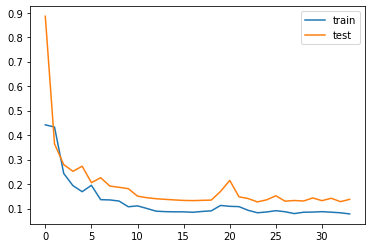

In [167]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [150]:
def build_model(hp):
    model = Sequential()
    #Numero de nodos en la primera capa 
    hp_units1 = hp.Choice('input_unit1',[25,50,100])
    model.add(Dense(units = hp_units1, input_shape=(n_timesteps, n_features)))
    hp_units2 = hp.Choice('input_unit2',[25,50,100])
    model.add(Dense(units = hp_units2))
    hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
    model.add(Dropout(hp_dropout))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model

In [151]:
tuner1= BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=5,
        num_initial_points=2,
        seed = 123,
        overwrite=True
        )

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [152]:
#Si esto da un error que dice algo de Oracle, se arregla borrando los json que hay en /untitle_project
tuner1.search(
        x=train_x,
        y=train_y,
        epochs=200,
        batch_size=128,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)

Trial 5 Complete [00h 00m 07s]
val_loss: 0.3778921961784363

Best val_loss So Far: 0.3778921961784363
Total elapsed time: 00h 00m 33s
INFO:tensorflow:Oracle triggered exit


In [153]:
model = tuner1.get_best_models(num_models=1)[0]

In [98]:
def prediction(datos_test_x, datos_test_y, n_input, modelo, steps, features):
    test_y = datos_test_y
    test_x = datos_test_x
    n_timesteps=steps
    n_features=features
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos el índice i a 0
    i=0
    for i in range(len(test_x)):
        data = test_x[i,:,:]
        input_x = data.reshape((1, n_timesteps, n_features))
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 

        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        if i < len(test_x):
            try: test_x[i+1,0,0] = yhat[0]
            except IndexError: continue
        else: break
            
    predictions = array(predictions)
    
    return predictions,test_x

In [100]:
prediction,test_x = prediction(test_x, test_y, n_input, model, n_timesteps, n_features)

In [168]:
prediction = model.predict(test_x)
prediction

array([[[-1.123797 ]],

       [[-1.2355311]],

       [[-1.3428953]],

       ...,

       [[-2.443011 ]],

       [[-2.4864929]],

       [[-2.5643384]]], dtype=float32)

In [170]:
prediction.shape

(1051, 1, 1)

In [171]:
prediction = prediction.reshape(prediction.shape[0],prediction.shape[1])

In [172]:
prediction = scaler_y.inverse_transform(prediction)
test_y = scaler_y.inverse_transform(test_y)

In [173]:
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.304
Test CVRMSE: 10.253
Test R squared: 0.918


In [106]:
pred = pd.DataFrame(prediction).groupby(pd.DataFrame(prediction).index // 6).mean()
real = pd.DataFrame(test_y).groupby(pd.DataFrame(test_y).index // 6).mean()
rmse = np.sqrt(mean_squared_error(real, pred))
r2 = r2_score(real, pred)
cvrmse = rmse/np.mean(real)*100
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 1.818
Test CVRMSE: 61.282
Test R squared: -2.273


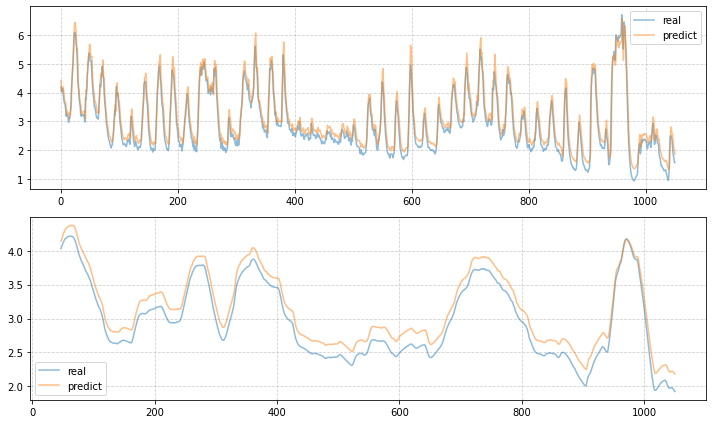

In [174]:
#EDIFICIO A 
fig, axs = plt.subplots(figsize=(10,6), nrows = 2, ncols =1, sharex =False)
#fig = plt.figure(figsize =(15, 5))
axs[0].plot(test_y, label='real',alpha=0.5)
axs[0].plot(prediction, label='predict', alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.6)
axs[0].legend()
#Media móvil por horas
axs[1].plot(pd.DataFrame(test_y).rolling(48).mean(), label='real',alpha=0.5)
axs[1].plot(pd.DataFrame(prediction).rolling(48).mean(), label='predict', alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.6)
axs[1].legend()
fig.tight_layout()
plt.show()

In [130]:
#SIN ACTUALIZAR
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.622
Test CVRMSE: 20.957
Test R squared: 0.656


In [131]:
pred = pd.DataFrame(prediction).groupby(pd.DataFrame(prediction).index // 6).mean()
real = pd.DataFrame(test_y).groupby(pd.DataFrame(test_y).index // 6).mean()
rmse = np.sqrt(mean_squared_error(real, pred))
r2 = r2_score(real, pred)
cvrmse = rmse/np.mean(real)*100
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.569


TypeError: cannot convert the series to <class 'float'>

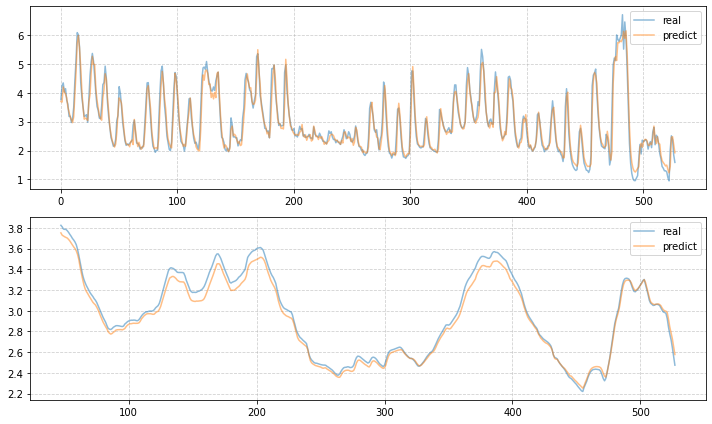

In [146]:
#EDIFICIO A SIN ACTUALIZAR
fig, axs = plt.subplots(figsize=(10,6), nrows = 2, ncols =1, sharex =False)
#fig = plt.figure(figsize =(15, 5))
axs[0].plot(test_y, label='real',alpha=0.5)
axs[0].plot(prediction, label='predict', alpha=0.5)
axs[0].grid(linestyle = "--", alpha=0.6)
axs[0].legend()
#Media móvil por horas
axs[1].plot(pd.DataFrame(test_y).rolling(48).mean(), label='real',alpha=0.5)
axs[1].plot(pd.DataFrame(prediction).rolling(48).mean(), label='predict', alpha=0.5)
axs[1].grid(linestyle = "--", alpha=0.6)
axs[1].legend()
fig.tight_layout()
plt.show()